In [3]:
import sys
sys.path.append('../')

import torch
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from tqdm import tqdm
from tasks import LauraTaskWrapper
from architecture import SequentialModel
from tasks import NeuroGymWrapper
import matplotlib as mpl
import lyapynov as lp


SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 16
BIGGEST_SIZE = 17

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGEST_SIZE)  # fontsize of the figure title

torch_to_np = lambda x: x.detach().cpu().numpy()

In [121]:
from lyapynov import DynamicalSystem 

def LCE(system : DynamicalSystem, p : int, n_forward : int, n_compute : int, keep : bool):
    '''
    Compute LCE.
        Parameters:
            system (DynamicalSystem): Dynamical system for which we want to compute the LCE.
            p (int): Number of LCE to compute.
            n_forward (int): Number of steps before starting the LCE computation. 
            n_compute (int): Number of steps to compute the LCE, can be adjusted using keep_evolution.
            keep (bool): If True return a numpy array of dimension (n_compute,p) containing the evolution of LCE.
        Returns:
            LCE (numpy.ndarray): Lyapunov Charateristic Exponents.
            history (numpy.ndarray): Evolution of LCE during the computation.
    '''
    # Forward the system before the computation of LCE
    system.forward(n_forward, False)

    # Computation of LCE
    W = np.eye(system.dim)[:,:p]
    LCE = np.zeros(p)
    if keep:
        history = np.zeros((n_compute, p))
        for i in range(1, n_compute + 1):
            W = system.next_LTM(W)
            system.forward(1, False)
            W, R = np.linalg.qr(W)
            for j in range(p):
                LCE[j] += np.log(np.abs(R[j,j]))
                history[i-1,j] = LCE[j] / (i * system.dt)
        LCE = LCE / (n_compute * system.dt)
        return LCE, history
    else:
        for _ in range(n_compute):
            W = system.next_LTM(W)
            system.forward(1, False)
            W, R = np.linalg.qr(W)
            for j in range(p):
                LCE[j] += np.log(np.abs(R[j,j]))
        LCE = LCE / (n_compute * system.dt)
        return LCE



Load the model and setup the testing set:

In [122]:
from analysis_utils import load_checkpoints, import_checkpoint
# ch_path = 'scale_sweeps_1_10/DelayMatchSample-v0/grid_20/'
ch_path = 'flip_flop_manual/'
checkpoints = list(load_checkpoints(ch_path)[0])

In [123]:
def eval_at_iter(iter, checkpoints, inputs, targets, to_np = True):
    model = torch.jit.script(SequentialModel())
    model.load_state_dict(import_checkpoint(checkpoints[iter]))
    hidden, adjoint, output, loss_unreduced, loss = model.analysis_mode(inputs, targets)
    if to_np:
        hidden, adjoint, output, loss_unreduced, loss = torch_to_np(hidden), torch_to_np(adjoint), torch_to_np(output), torch_to_np(loss_unreduced), torch_to_np(loss)
    return model, hidden, adjoint, output, loss_unreduced, loss

def eval_simple_at_iter(iter, checkpoints, inputs, to_np = True):
    model = torch.jit.script(SequentialModel())
    model.load_state_dict(import_checkpoint(checkpoints[iter]))
    hidden = model(inputs)[1]
    if to_np:
        hidden = torch_to_np(hidden)
    return model, hidden

In [124]:
task_test  = LauraTaskWrapper('flip_flop', 100, use_noise = False, n_samples = 100, n_spike = 20, T = 300)
inputs, targets = task_test()

# Hamiltonian Part

## Mid-Training Adjoint, State and Hamiltonian

In [41]:
def H(hidden, adjoint, losses_unreduced):
    # Compute Hamiltonian = <h(t | x), a(t | y*)> + ell(z(t | x), y*(t)).
    return (hidden * adjoint).sum(-1) + losses_unreduced.sum(-1) / losses_unreduced.size

In [81]:
# Compute trajectories, etc mid training for analysis:
model, hidden, adjoint, output, loss_unreduced, loss = eval_at_iter(10, checkpoints, inputs, targets)
ham = H(hidden, adjoint, loss_unreduced)
print('Ham shape is (B, T) =', ham.shape)

Ham shape is (B, T) = (100, 300)


Compute Hamiltonian Over GD to Verify Pontroyagin's Principle:

In [ ]:
hams = []
for iter in tqdm(range(len(checkpoints))):
    model, hidden, adjoint, output, loss_unreduced, loss = eval_at_iter(iter, checkpoints, inputs, targets)
    hams.append(H(hidden, adjoint, loss_unreduced))
hams = np.stack(hams)

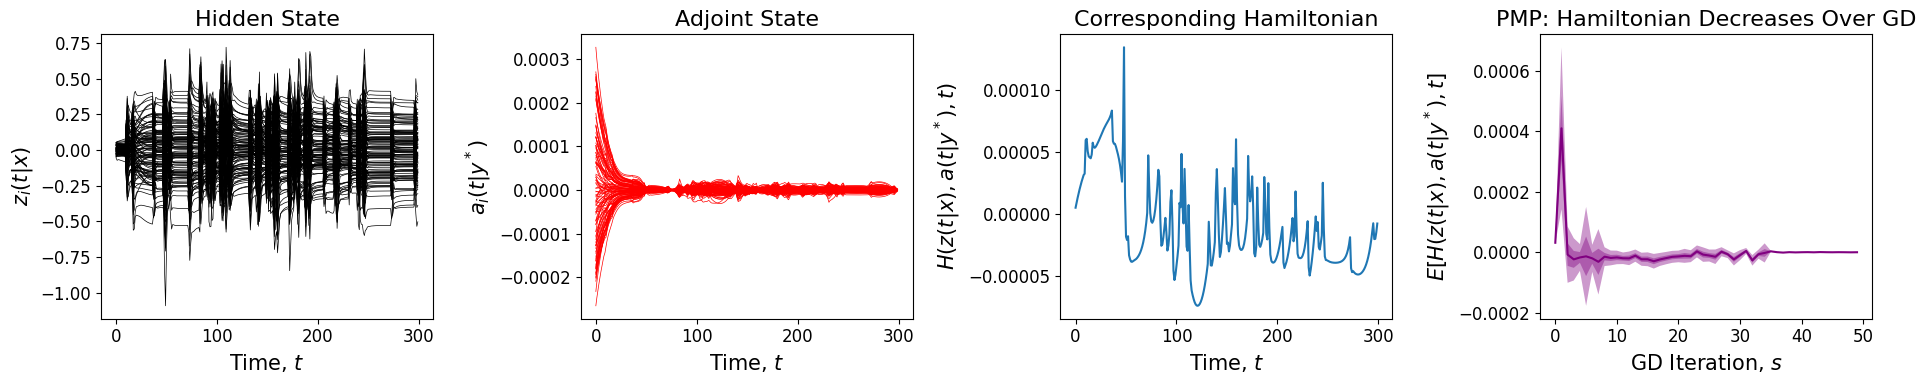

In [109]:
plt.figure(figsize = (19, 4))
plt.subplot(1,4,1)
plt.title('Hidden State')
plt.xlabel('Time, $t$')
plt.ylabel('$z_i(t|x)$')
plt.plot(hidden[0, :, :], linewidth = .5, color = 'black')

plt.subplot(1,4,2)
plt.plot(adjoint[0, :, :], linewidth = .5, color = 'red')
plt.title('Adjoint State')
plt.xlabel('Time, $t$')
plt.ylabel('$a_i(t|y^*)$')

plt.subplot(1,4,3)
plt.plot(ham[0])
plt.xlabel('Time, $t$')
plt.ylabel('$H(z(t|x), a(t|y^*), t)$')
plt.title('Corresponding Hamiltonian')

plt.subplot(1,4,4)
mu = hams.mean((1,2))
var = hams.std((1,2))
plt.plot(mu, color = 'purple')
plt.fill_between(np.arange(hams.shape[0]), mu - .5 * var, mu + .5 * var, alpha = .4, zorder = -1, facecolor = 'purple')
plt.fill_between(np.arange(hams.shape[0]), mu - .2 * var, mu + .2 * var, alpha = .4, zorder = -1, facecolor = 'purple')
plt.ylabel('$E[H(z(t|x), a(t|y^*), t]$')
plt.xlabel('GD Iteration, $s$')
plt.title('PMP: Hamiltonian Decreases Over GD')

plt.tight_layout()
plt.savefig('hammain.png')
plt.savefig('hammain.pdf')
plt.show()

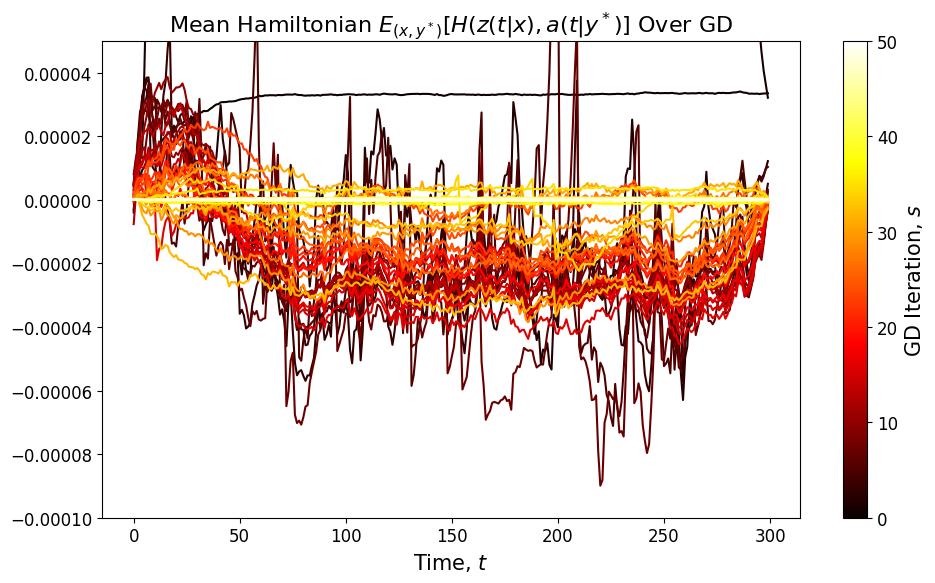

In [91]:
plt.figure(figsize = (10, 6))
cmap = plt.get_cmap('hot')
for i in range(hams.shape[0]):
    plt.plot(hams[i].mean(0), color = cmap(i / hams.shape[0]))
    plt.ylim(-0.0001, 0.00005)

plt.xlabel('Time, $t$')
plt.title('Mean Hamiltonian $E_{(x,y^*)}[H(z(t|x), a(t|y^*)]$ Over GD')
plt.gcf().colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0, hams.shape[0]), cmap='hot'),
             ax=plt.gca(), orientation='vertical', label='GD Iteration, $s$')
plt.tight_layout()
plt.savefig('suppham.pdf')
plt.show()

# Lyapunov Part

### Evaluate Model

In [126]:
LCEs = []
for iter in tqdm(range(len(checkpoints))):
    model, hidden = eval_simple_at_iter(iter, checkpoints, inputs, to_np = False)
    jacs = torch.autograd.functional.jacobian(lambda h: model.cuda().eval_single_step(h)[1], hidden[0, :, :].cuda())
    hidden = torch_to_np(hidden)

    T = jacs.shape[0]
    jacs = jacs[range(T), :, range(T), :].detach().cpu().numpy()

    f  = lambda x, t: hidden[0, int(round(t))+1]
    jac = lambda x, t:  jacs[int(round(t))]

    np.random.seed(0)
    sys = lp.DiscreteDS(hidden[0, 0], 0, f, jac)
    LCEs.append(lp.LCE(sys, 20, 0, hidden.shape[1] - 1, False))
LCEs = np.stack(LCEs)

100%|██████████| 50/50 [14:49<00:00, 17.79s/it]


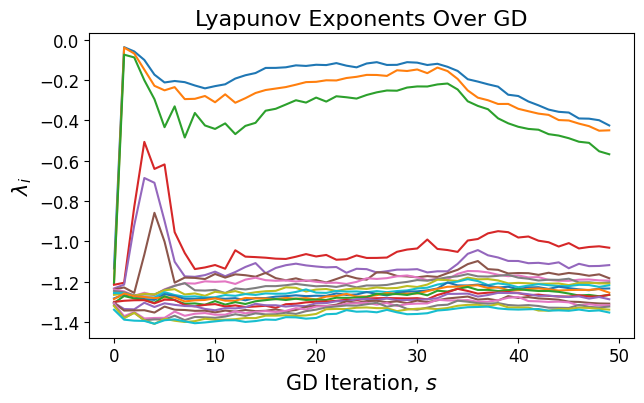

In [189]:
plt.figure(figsize = (5.5 * 1.2, 3.5 * 1.2))
plt.plot(LCEs)
plt.xlabel('GD Iteration, $s$', fontsize = 15)
plt.title('Lyapunov Exponents Over GD', fontsize = 16)
plt.ylabel('$\\lambda_i$', fontsize = 15)
# plt.axhline(0., linestyle = 'dashed', zorder = -1, alpha = 0.5, color = 'black')
# plt.text(LCEs.shape[0] * 0.6, 0.03, 'Stability Threshold')
plt.savefig('lyap_flip_flop_over_training.pdf')
plt.savefig('lyap_flip_flop_over_training.png')
plt.tight_layout()
plt.show()

# Fixed Points

In [159]:
task_test  = LauraTaskWrapper('flip_flop', 100, use_noise = False, n_samples = 100, n_spike = 80, T = 300)
inputs, targets = task_test()

In [160]:
# Compute trajectories, etc mid training for analysis:
model, hidden, adjoint, output, loss_unreduced, loss = eval_at_iter(10, checkpoints, inputs, targets)
vel = hidden[:, 1:] - hidden[:, :-1]
vel_adj = adjoint[:, 1:] - adjoint[:, :-1]

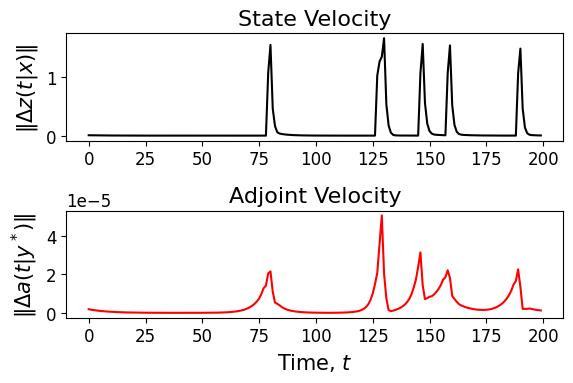

In [188]:
plt.figure(figsize = (6, 4))
plt.subplot(2,1,1)
b = 0
plt.plot(np.linalg.norm(vel, axis = -1)[b, 50:250], color = 'black')
plt.title('State Velocity')
plt.ylabel('$\\|\\Delta z(t|x)\\|$')
plt.subplot(2,1,2)
plt.plot(np.linalg.norm(vel_adj, axis = -1)[b, 50:250], color = 'red')
plt.title('Adjoint Velocity')
plt.xlabel('Time, $t$')
plt.ylabel('$\\|\\Delta a(t|y^*)\\|$')
plt.tight_layout()
plt.savefig('vel_state_adj.pdf')
plt.savefig('vel_state_adj.png')
plt.show()


# State Transition Matrix in Depth

In [342]:
def fundamental_matrix(jacs):
    # Iteratively compute:
    # M(t+1) = J(t) * Q(t), [Q(t+1), R(t+1)] = qr(M(t+1)).
    # Fundamental matrix is given by U(t) = Q(t) * R(t) * R(t-1) ... * R(1).
    Q = np.eye(*jacs[0].shape)
    Rs = []
    Qs = []
    for J in jacs:
        M = J @ Q 
        Q, R = np.linalg.qr(M)
        Rs.append(np.copy(R))
        Qs.append(np.copy(Q))

    Rs_cum = []
    R_cum = np.eye(*jacs[0].shape)
    Us = []
    for Q, R in zip(Qs, Rs):
        R_cum = R @ R_cum
        Us.append(Q @ R_cum)
        Rs_cum.append(np.copy(R_cum))

    Qs, Rs_cum, Us = np.stack(Qs), np.stack(Rs_cum), np.stack(Us) # All are shape (len(jacs), n, n)
    return Qs, Rs_cum, Us

def state_transition(Q, R_cum, i1, i2):
    return Q[i1] @ R_cum[i1] @ np.linalg.inv(R_cum[i2]) @ Q[i2].T

Compute Jacobians for recurrent model:

In [196]:
model, hidden, adjoint, output, loss_unreduced, loss = eval_at_iter(10, checkpoints, inputs, targets, to_np = False)

jacs = torch.autograd.functional.jacobian(lambda h: model.eval_single_step(h, inputs[0, :, :])[1], hidden[0, :, :])
T = jacs.shape[0]
jacs = jacs[range(T), :, range(T), :].detach().cpu().numpy()

In [343]:
Qs, Rs, Us = fundamental_matrix(jacs)
Us_trans = Us.swapaxes(1,2)

Test out the state transition by perturbing the initial conditions and guessing what should happen with it.

In [275]:
h0_perb = .01 * hidden[0, -1]
h_perb = torch_to_np(model(inputs[:1], h0_perb[None])[1][0] - hidden[0])
h_perb_guess = Us @ torch_to_np(h0_perb)

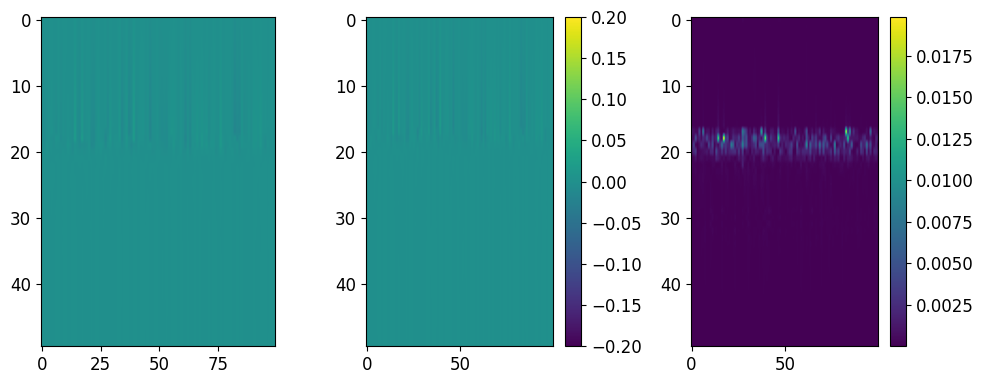

In [277]:
plt.figure(figsize = (10, 4))
plt.subplot(1,3,1)
plt.imshow(h_perb[:50], aspect = 'auto', vmin = -0.2, vmax = 0.2)
plt.subplot(1,3,2)
plt.imshow(h_perb_guess[:50], aspect = 'auto', vmin = -0.2, vmax = 0.2)
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(np.abs(h_perb_guess - h_perb)[:50], aspect = 'auto')
plt.colorbar()
plt.tight_layout()
plt.show()

In [300]:
def grad_z_of_ell(model, inputs, targets, to_np = True):
    hidden, adjoint, out, ell_z, loss = model.analysis_mode(inputs, targets)
    diffs = out - targets
    res_term = (2. / ell_z.numel()) * diffs @ model.W_out.weight.data
    if to_np:
        return torch_to_np(res_term)
    return res_term

adj_drive = grad_z_of_ell(model, inputs, targets)[0]
adj_drive.shape

(300, 100)

In [304]:
model, hidden, adjoint, output, loss_unreduced, loss = eval_at_iter(10, checkpoints, inputs, targets, to_np = True)

In [321]:
guess_adj = 0.
for Ut, ad in zip(Us_trans, adj_drive):
    guess_adj += Ut @ ad

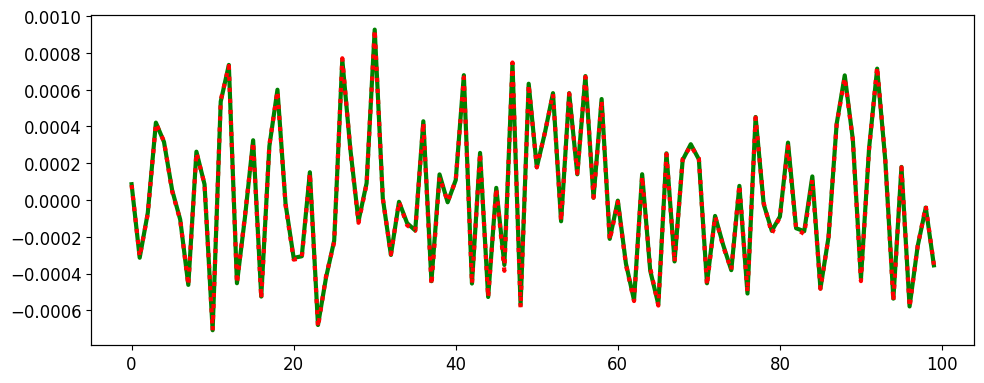

In [330]:
plt.figure(figsize = (10, 4))
plt.plot(adjoint[0,0], color = 'green', linewidth = 3)
plt.gca().twinx()
plt.plot(guess_adj, color = 'red', linestyle = 'dotted', linewidth = 3)
plt.yticks([])
plt.tight_layout()

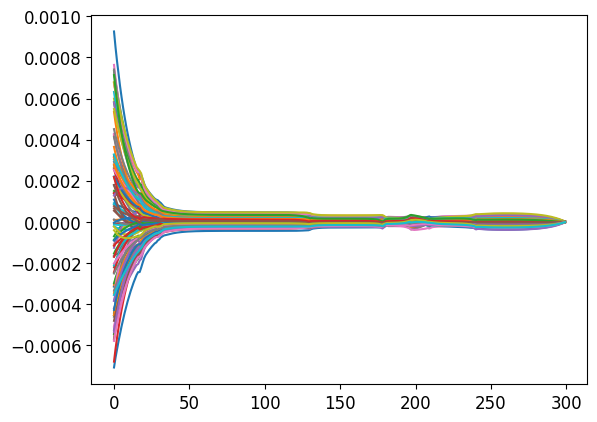

In [334]:
plt.plot(adjoint[0])
plt.show()



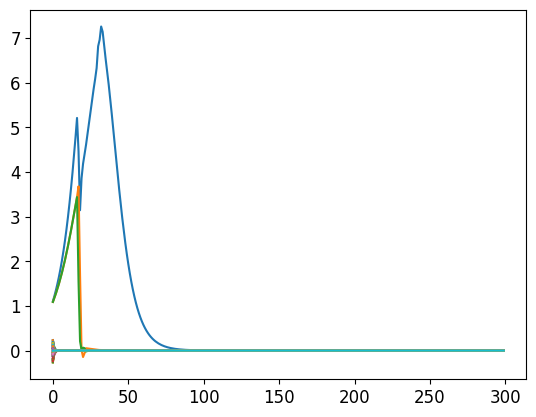

In [340]:
plt.plot(np.linalg.eigvals(Us))
plt.show()

In [348]:
print(np.linalg.eigvals(state_transition(Qs, Rs, 50, 10)))

[ 7.93431732e+07+0.00000000e+00j  1.05735420e+00+0.00000000e+00j
 -1.62438075e-01+0.00000000e+00j  5.02687592e-02+0.00000000e+00j
 -3.22282232e-02+1.51475776e-02j -3.22282232e-02-1.51475776e-02j
 -2.57320545e-03+0.00000000e+00j  7.63666674e-04+1.48409858e-03j
  7.63666674e-04-1.48409858e-03j -3.57883859e-04+0.00000000e+00j
  8.03598284e-05+1.82041003e-04j  8.03598284e-05-1.82041003e-04j
  1.34443120e-04+5.58603819e-05j  1.34443120e-04-5.58603819e-05j
 -8.05011763e-05+0.00000000e+00j  5.27365007e-05+5.70792409e-05j
  5.27365007e-05-5.70792409e-05j  2.50056248e-05+2.10590971e-05j
  2.50056248e-05-2.10590971e-05j -1.89703663e-05+2.57817353e-05j
 -1.89703663e-05-2.57817353e-05j -5.60913062e-06+1.94567408e-06j
 -5.60913062e-06-1.94567408e-06j  4.62184955e-06+1.14778995e-06j
  4.62184955e-06-1.14778995e-06j  1.17015757e-06+1.57765372e-06j
  1.17015757e-06-1.57765372e-06j -1.05780609e-06+6.27153836e-07j
 -1.05780609e-06-6.27153836e-07j  3.70918793e-07+6.34532414e-07j
  3.70918793e-07-6.345324

In [351]:
Qs_all, Rs_all, Us_all = [], [], []
for iter in tqdm([0, 10, -1]):
    model, hidden, adjoint, output, loss_unreduced, loss = eval_at_iter(iter, checkpoints, inputs, targets, to_np = False)

    jacs = torch.autograd.functional.jacobian(lambda h: model.eval_single_step(h, inputs[0, :, :])[1], hidden[0, :, :])
    T = jacs.shape[0]
    jacs = jacs[range(T), :, range(T), :].detach().cpu().numpy()

    Qs, Rs, Us = fundamental_matrix(jacs)
    Qs_all.append(Qs)
    Rs_all.append(Rs)
    Us_all.append(Us)

100%|██████████| 3/3 [01:08<00:00, 22.88s/it]


In [352]:
Qs_all, Rs_all, Us_all = np.stack(Qs_all), np.stack(Rs_all), np.stack(Us_all)

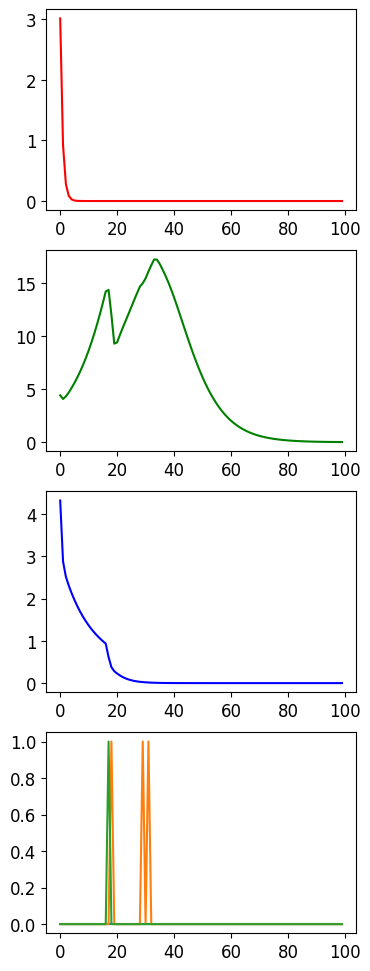

In [370]:
plt.figure(figsize = (4, 12))
colors = ['red', 'green', 'blue']
for i in range(Us_all.shape[0]):
    plt.subplot(4,1,1+i)
    plt.plot(np.linalg.norm(Us_all[i][:100], axis = (1, 2)), color = colors[i], zorder = -i)

plt.subplot(4,1,4)
plt.plot(inputs[0, :100])
plt.show()

# Misc:

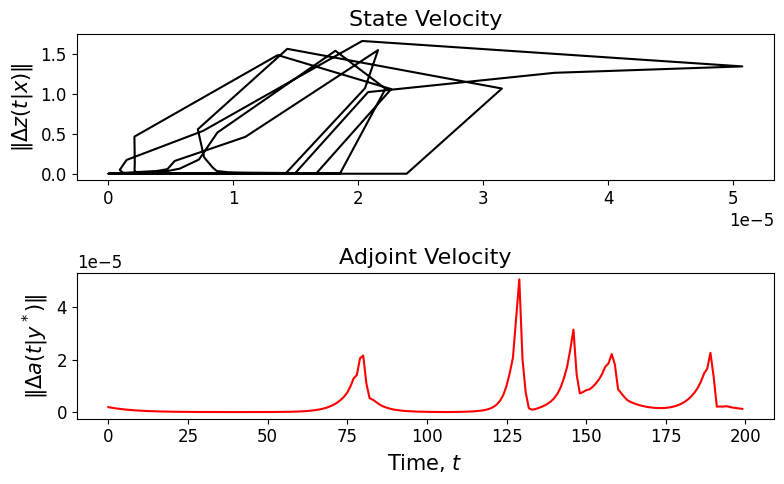

In [185]:
plt.figure(figsize = (8, 5))
plt.subplot(2,1,1)
b = 0
plt.plot(np.linalg.norm(vel_adj, axis = -1)[b, 50:250], np.linalg.norm(vel, axis = -1)[b, 50:250], color = 'black')
plt.title('State Velocity')
plt.ylabel('$\\|\\Delta z(t|x)\\|$')
plt.subplot(2,1,2)
plt.plot(np.linalg.norm(vel_adj, axis = -1)[b, 50:250], color = 'red')
plt.title('Adjoint Velocity')
plt.xlabel('Time, $t$')
plt.ylabel('$\\|\\Delta a(t|y^*)\\|$')
plt.tight_layout()
plt.savefig('vel_state_adj.pdf')
plt.savefig('vel_state_adj.png')
plt.show()

In [9]:
hidden, adjoint = hidden.detach().cpu().numpy(), adjoint.detach().cpu().numpy()

Max difference: 0.0


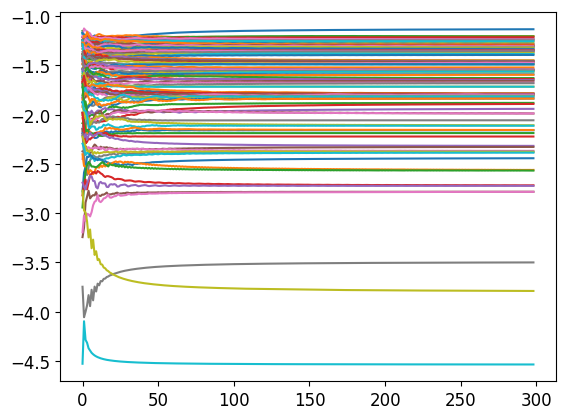

In [11]:
# Create a dynamical system by just replaying the original forward states.
f  = lambda x, t: hidden[0, int(round(t))+1]
jac = lambda x, t:  jacs[int(round(t))]

sys = lp.DiscreteDS(hidden[0, 0], 0, f, jac)

# Test sys produces same as hidden
ls = [np.copy(sys.x)]
for i in range(hidden.shape[1] - 1):
    sys.next()
    ls.append(np.copy(sys.x))
ls = np.stack(ls, 0)
print('Max difference:', (ls - hidden[0]).max())

# np.random.seed(0)
sys = lp.DiscreteDS(hidden[0, 0], 0, f, jac)
mLCE, history_z = lp.LCE(sys, 100, 0, hidden.shape[1] - 1, True)
plt.plot(history_z)
plt.show()

In [12]:
def my_CLV(system : DynamicalSystem, p : int, n : int, traj : bool):
    '''
    Compute CLV.
        Parameters:
            system (DynamicalSystem): Dynamical system for which we want to compute the mLCE.
            p (int): Number of CLV to compute.
            n (int): Number of time steps for which Phi and R matrices are stored and for which CLV are computed.
            traj (bool): If True return a numpy array of dimension (n_B,system.dim) containing system's trajectory at the times CLV are computed.
        Returns:
            CLV (List): List of numpy.array containing CLV computed during n_B time steps.
            history (numpy.ndarray): Trajectory of the system during the computation of CLV.
    '''
    # Make W converge to Phi
    W = np.eye(system.dim)[:,:p]
    
    # We continue but now Q and R are stored to compute CLV later
    Phi_list, R_list1 = [W], []
    if traj:
        history = np.zeros((n+1, system.dim))
        history[0,:] = system.x

    for i in range(n):
        W = system.next_LTM(W)
        W, R = np.linalg.qr(W)
        Phi_list.append(W)
        R_list1.append(R)
        system.forward(1, False)
        if traj:
            history[i+1,:] = system.x

    A = np.triu(np.random.rand(p,p))


    # Compute CLV
    CLV = [Phi_list[-1] @ A]
    for Q, R in zip(reversed(Phi_list[:-1]), reversed(R_list1)):
        C = np.diag(1. / np.linalg.norm(A, axis = 0))
        B = A @ C
        A = np.linalg.solve(R, B)
        CLV_t = Q @ A
        CLV.append(CLV_t / np.linalg.norm(CLV_t, axis = 0))
    del R_list1
    # del Phi_list
    CLV.reverse()

    if traj:
        return Phi_list, history
    return Phi_list

(300, 100, 100)


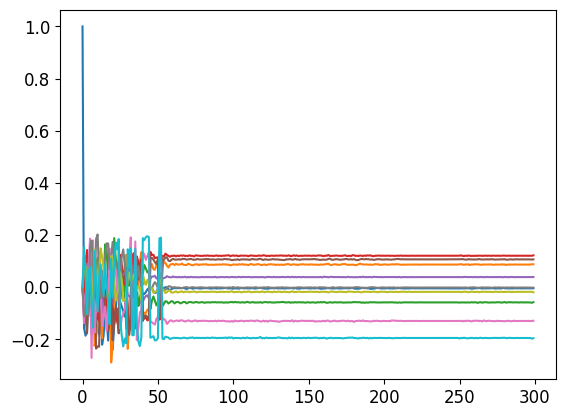

(300, 100)


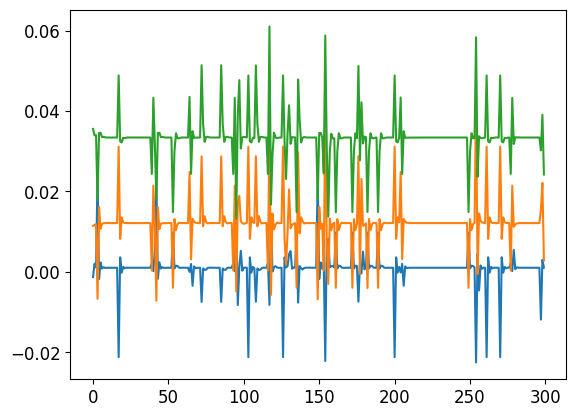

In [14]:
sys = lp.DiscreteDS(hidden[0, 0], 0, f, jac)
clv, history = my_CLV(sys, p = 100, n = hidden.shape[1] - 1, traj = True) 

clv = np.stack(clv).swapaxes(1,2) # (time, rows, columns). Each row is a basis vector. 
print(clv.shape)

plt.plot(clv[:, 0, :10])
plt.show()

print(history.shape)
plt.plot(history @ model.W_out.weight.data.cpu().numpy().T)
plt.show()

In [15]:
sys_adjoint = lp.DiscreteDS(hidden[0, 0], 0, f, lambda x, t:  jacs[T - 1 - int(round(t))].T)
clv_adj, history = my_CLV(sys_adjoint, p = 100, n = hidden.shape[1] - 1, traj = True) # (sys, p = 10, n_forward = 0, n_A = 0, n_B = hidden.shape[1] - 1, n_C = 0, traj = True)

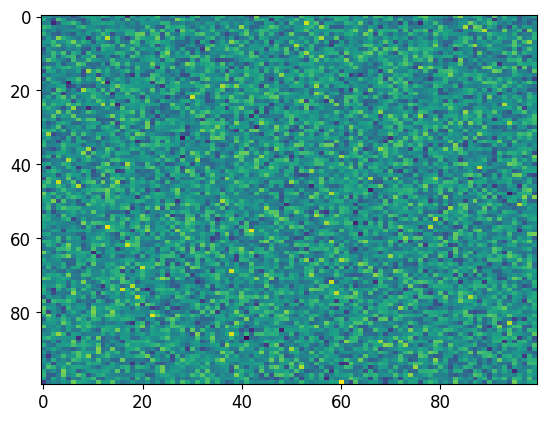

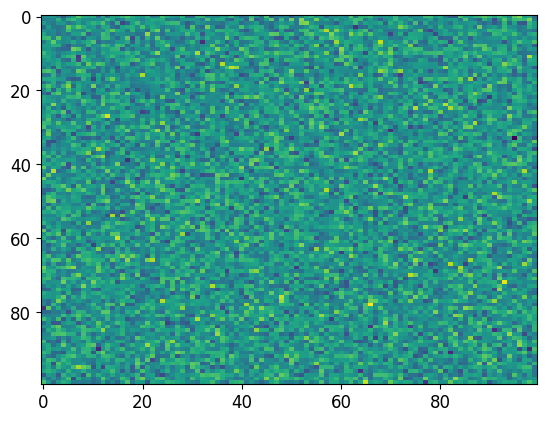

In [16]:
plt.imshow(clv[-1].T, aspect= 'auto')
plt.figure()
plt.imshow(clv_adj[-1], aspect= 'auto')

(300, 100, 100)


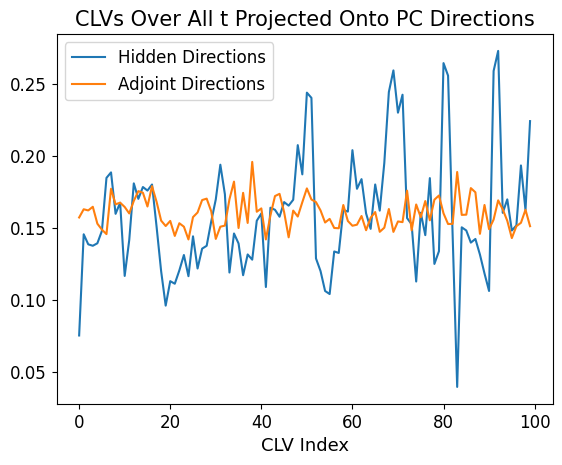

In [17]:
from sklearn.decomposition import PCA
import matplotlib.animation as animation

pca = PCA(3)
proj = pca.fit_transform(hidden.reshape(-1, hidden.shape[-1])).reshape((*hidden.shape[:-1], 3))

shifted_clv = clv + pca.mean_[None, None] # Shift CLV so it's centered at same mean. PCA subtracts mean before projecting.

norms = []
for d in range(shifted_clv.shape[1]):
    clv_proj = pca.transform(shifted_clv[:, d, :]) # (tsteps, 3)
    norms.append(np.mean(np.linalg.norm(clv_proj, axis = -1)))

shifted_clv_adj = clv_adj + pca.mean_[None, None] # Shift CLV so it's centered at same mean. PCA subtracts mean before projecting.
norms_adj = []
for d in range(shifted_clv.shape[1]):
    clv_proj = pca.transform(shifted_clv_adj[:, d, :]) # (tsteps, 3)
    norms_adj.append(np.mean(np.linalg.norm(clv_proj, axis = -1)))

print(shifted_clv.shape)

plt.plot(norms)
plt.plot(norms_adj)
plt.legend(['Hidden Directions', 'Adjoint Directions'])
plt.title('CLVs Over All t Projected Onto PC Directions')
plt.xlabel('CLV Index')
plt.show()

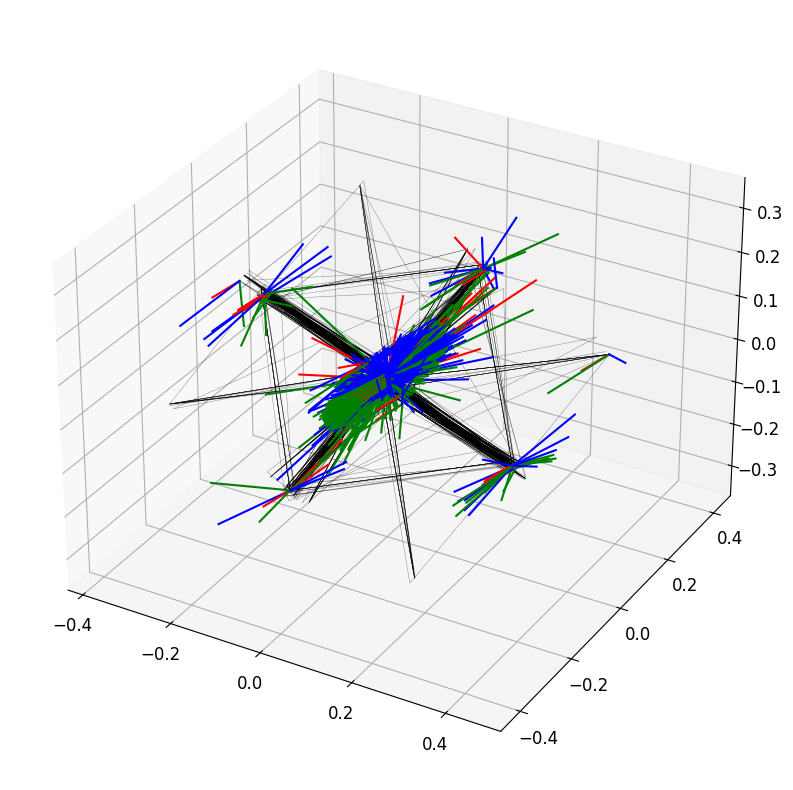

In [18]:
plt.figure(figsize = (10, 10))
plt.axes(projection='3d')

cmap = plt.get_cmap('cool')
for idx in range(50):
    plt.plot(proj[idx, :, 0], proj[idx, :, 1], proj[idx, :, 2], color = 'black', alpha = .5, linewidth = .3)

shifted_clv = clv + pca.mean_[None, None] # Shift CLV so it's centered at same mean. PCA subtracts mean before projecting.

origins, arrows = [], []
for d in range(3):
    origins.append([])
    arrows.append([])
    clv_proj = pca.transform(shifted_clv[:, d, :]) # (tsteps, 3)
    for j in range(0, shifted_clv.shape[0], 1):
        origins[-1].append(proj[0, j, :])
        arrows[-1].append(proj[0, j, :] + clv_proj[j, :])

origins, arrows = np.array(origins), np.array(arrows)

for i in range(origins.shape[1]):
    plt.plot([origins[0, i, 0], arrows[0, i, 0]], [origins[0, i, 1], arrows[0, i, 1]], [origins[0, i, 2], arrows[0, i, 2]], color = 'red')
    plt.plot([origins[1, i, 0], arrows[1, i, 0]], [origins[1, i, 1], arrows[1, i, 1]], [origins[1, i, 2], arrows[1, i, 2]], color = 'green')
    plt.plot([origins[2, i, 0], arrows[2, i, 0]], [origins[2, i, 1], arrows[2, i, 1]], [origins[2, i, 2], arrows[2, i, 2]], color = 'blue')

plt.show()

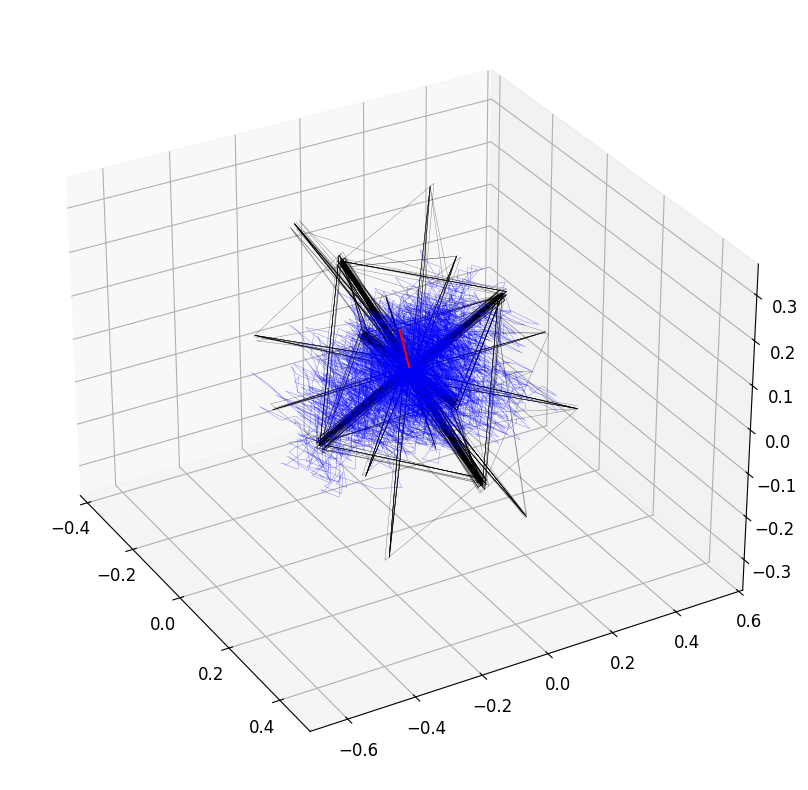

In [53]:
plt.figure(figsize = (10, 10))
plt.axes(projection='3d')

cmap = plt.get_cmap('cool')
for idx in range(50):
    plt.plot(proj[idx, :, 0], proj[idx, :, 1], proj[idx, :, 2], color = 'black', alpha = .5, linewidth = .3)

model.load_state_dict(import_checkpoint(checkpoints_all[1]))
hidden2, adjoint2 = model.analysis_mode(inputs, targets)[:2]
hidden2, adjoint2 = hidden2.detach().cpu().numpy(), adjoint2.detach().cpu().numpy()
# pca2 = PCA(3)
hidden2_shifted = hidden2 + pca.mean_[None, None]
proj2 = pca.transform(hidden2_shifted.reshape(-1, hidden2.shape[-1])).reshape((*hidden2.shape[:-1], 3))
for idx in range(50):
    plt.plot(proj2[idx, :, 0], proj2[idx, :, 1], proj2[idx, :, 2], color = 'blue', alpha = .5, linewidth = .3)


shifted_adj = adjoint + pca.mean_[None, None] # Shift so it's centered at same mean. PCA subtracts mean before projecting.
shifted_adj = shifted_adj.swapaxes(0,1) # (tsteps, batch, n)
shifted_adj = shifted_adj.mean(1).mean(0)[None, None]

origins, arrows = [], []
for d in range(1):
    origins.append([])
    arrows.append([])
    adj_proj = pca.transform(shifted_adj[:, d, :]) # (tsteps, 3)
    for j in range(0, shifted_adj.shape[0], 1):
        origins[-1].append(proj[0, j, :])
        arrows[-1].append(proj[0, j, :] + 1e6 * adj_proj[j, :])

origins, arrows = np.array(origins), np.array(arrows)

ax = plt.gca()
elevation = ax.elev # 45
azimuth = ax.azim # -45
roll = ax.roll # 10
plt.gca().view_init(30, -30)
for i in range(origins.shape[1]):
    plt.plot([origins[0, i, 0], arrows[0, i, 0]], [origins[0, i, 1], arrows[0, i, 1]], [origins[0, i, 2], arrows[0, i, 2]], color = 'red')
    # plt.plot([origins[1, i, 0], arrows[1, i, 0]], [origins[1, i, 1], arrows[1, i, 1]], [origins[1, i, 2], arrows[1, i, 2]], color = 'green')
    # plt.plot([origins[2, i, 0], arrows[2, i, 0]], [origins[2, i, 1], arrows[2, i, 1]], [origins[2, i, 2], arrows[2, i, 2]], color = 'blue')

plt.show()

### Animate Frame:

KeyboardInterrupt: 

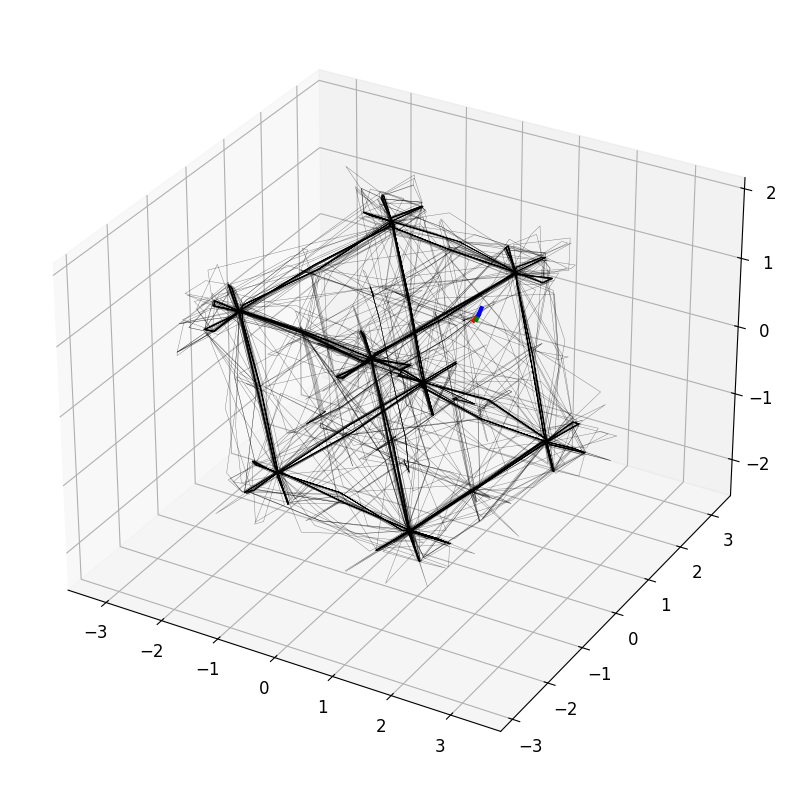

In [115]:

plt.figure(figsize = (10, 10))
plt.axes(projection='3d')

cmap = plt.get_cmap('cool')
for idx in range(50):
    plt.plot(proj[idx, :, 0], proj[idx, :, 1], proj[idx, :, 2], color = 'black', alpha = .5, linewidth = .3)

origins, arrows = [], []
for d in range(3):
    origins.append([])
    arrows.append([])
    clv_proj = pca.transform(shifted_clv[:, d, :]) # (tsteps, 3)
    for j in range(0, shifted_clv.shape[0], 1):
        origins[-1].append(proj[0, j, :])
        arrows[-1].append(proj[0, j, :] + clv_proj[j, :])

origins, arrows = np.array(origins), np.array(arrows)

ln1 = plt.plot([], [], [], c = 'red', linewidth = 3, zorder = 10)[0]
ln2 = plt.plot([], [], [], c = 'green', linewidth = 3, zorder = 10)[0]
ln3 = plt.plot([], [], [], c = 'blue', linewidth = 3, zorder = 10)[0]

def animate(i):
    ln1.set_data_3d([[origins[0, i, 0], arrows[0, i, 0]], [origins[0, i, 1], arrows[0, i, 1]], [origins[0, i, 2], arrows[0, i, 2]]])
    ln2.set_data_3d([[origins[1, i, 0], arrows[1, i, 0]], [origins[1, i, 1], arrows[1, i, 1]], [origins[1, i, 2], arrows[1, i, 2]]])
    ln3.set_data_3d([[origins[2, i, 0], arrows[2, i, 0]], [origins[2, i, 1], arrows[2, i, 1]], [origins[2, i, 2], arrows[2, i, 2]]])
    return ln1, ln2, ln3

ani = animation.FuncAnimation(plt.gcf(), animate, frames=range(origins.shape[1]), interval=100)
ani.save(filename="animation.gif", writer="pillow")
plt.show()

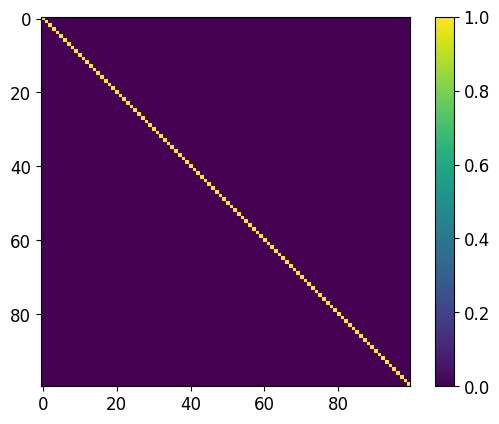

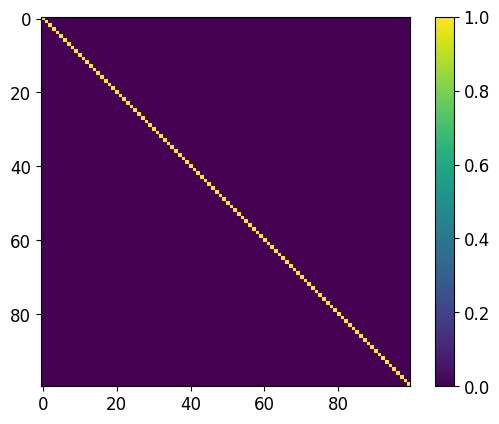

In [51]:
plt.imshow(clv[0] @ clv[0].T)
plt.colorbar()

Q, _= np.linalg.qr(clv[0])
plt.figure()
plt.imshow(Q.T @ Q)
plt.colorbar()

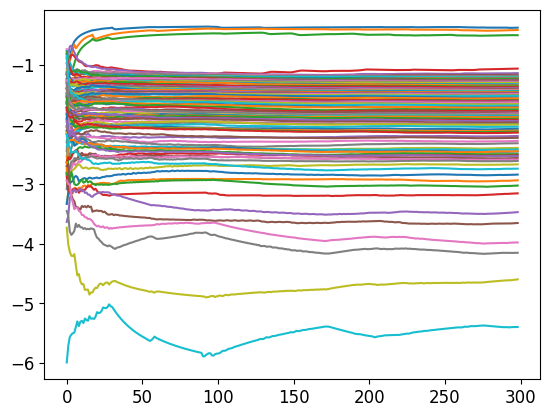

In [8]:
# Create a dynamical system by just replaying the original forward states.
adjoint_np = adjoint.detach().cpu().numpy()
T = adjoint_np.shape[1]
f = lambda x, t: adjoint_np[0, T - 2 - int(round(t))]
jac = lambda x, t:  jacs[T - 1 - int(round(t))].T

# np.random.seed(0)
sys = lp.DiscreteDS(adjoint_np[0, -1], 0, f, jac)
mLCE, history_a = LCE(sys, 100, 0, adjoint_np.shape[1] - 1, True)
plt.plot(history_a)
plt.show()

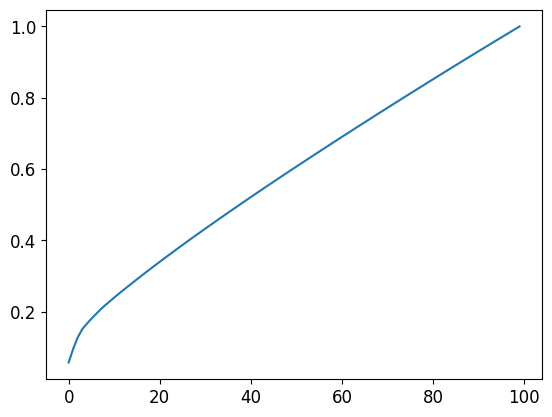

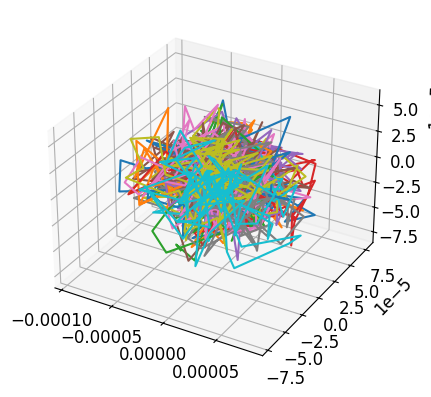

In [98]:
evol = np.zeros((1024, jacs.shape[0]+1, jacs.shape[1]))
for i in range(jacs.shape[0]):
    evol[:, i+1] = evol[:, i] @ jacs[i] + np.random.randn(*evol[:, i].shape) * .00001

from sklearn.decomposition import PCA
pca = PCA(100)
proj = pca.fit_transform(evol.reshape((-1, evol.shape[-1]))).reshape(evol.shape)
plt.plot(np.cumsum(pca.explained_variance_ratio_))

plt.figure()
plt.axes(projection = '3d')
for b in range(20):
    plt.plot(*proj[b, :, :3].T)
plt.show()

In [93]:
from analysis_utils import load_checkpoints, import_checkpoint
# ch_path = 'scale_sweeps_1_10/DelayMatchSample-v0/grid_20/'
model = torch.jit.script(SequentialModel().cuda())
model.load_state_dict(import_checkpoint(checkpoints[0]))

task_test  = LauraTaskWrapper('flip_flop', 1000, use_noise = False, n_samples = 1000, n_spike = 20, T = 90)
# task_test  = NeuroGymWrapper('DelayMatchSample-v0', 100)
inputs, targets = task_test()
hidden, adjoint = model.analysis_mode(inputs.cuda(), targets.cuda())[:2]

jacs = torch.autograd.functional.jacobian(lambda h: model.cpu().eval_autonomous_simple(h)[1], hidden[0, :, :].cpu())
T = jacs.shape[0]
jacs = jacs[range(T), :, range(T), :].detach().cpu().numpy()

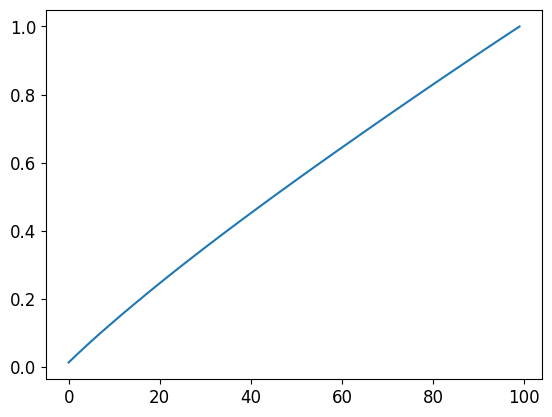

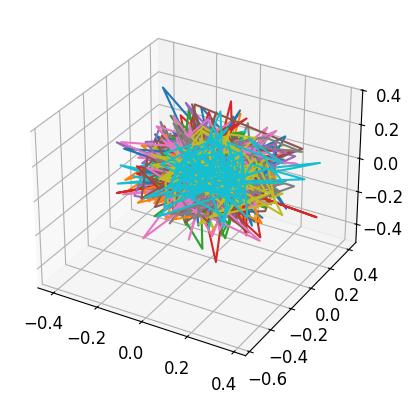

In [94]:
evol = np.zeros((1024, jacs.shape[0]+1, jacs.shape[1]))
for i in range(jacs.shape[0]):
    evol[:, i+1] = evol[:, i] @ jacs[i] + np.random.randn(*evol[:, i].shape) * .1

from sklearn.decomposition import PCA
pca = PCA(100)
proj = pca.fit_transform(evol.reshape((-1, evol.shape[-1]))).reshape(evol.shape)
plt.plot(np.cumsum(pca.explained_variance_ratio_))

plt.figure()
plt.axes(projection = '3d')
for b in range(20):
    plt.plot(*proj[b, :, :3].T)
plt.show()

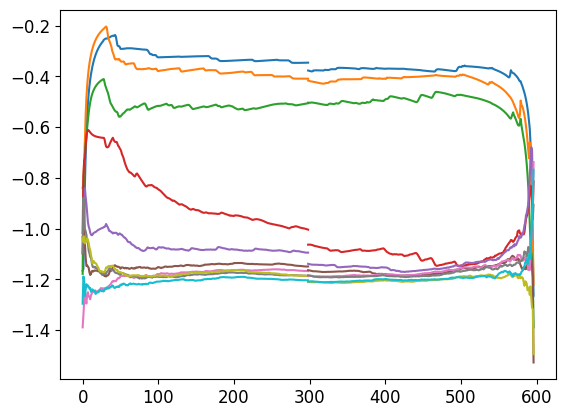

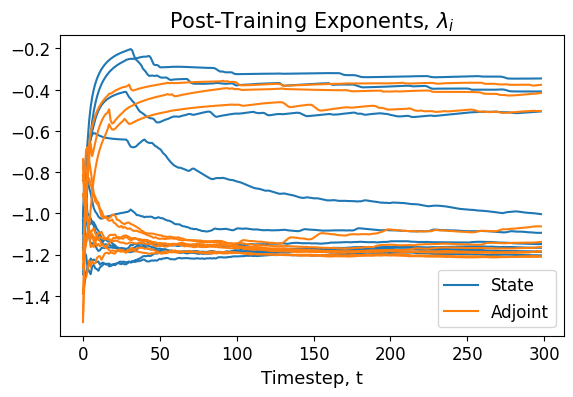

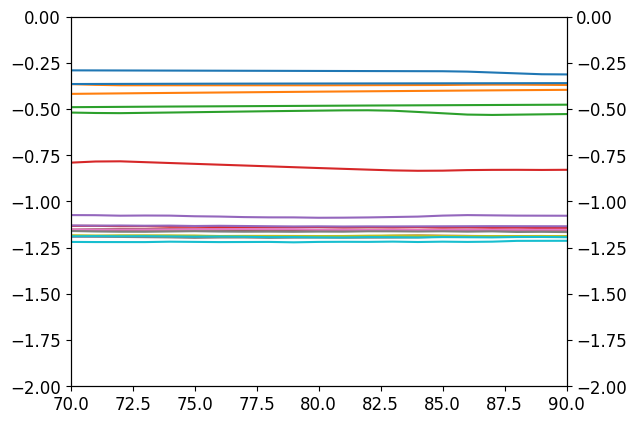

In [95]:
plt.plot(history_z[:, :10])
plt.plot(len(history_z)-1 + np.arange(len(history_z)), history_a[::-1, :10])
plt.show()

plt.figure(figsize=(5*1.3, 3*1.3))

lns = plt.plot(history_z[:, :10], color = '#1f77b4')
lns2 = plt.plot(history_a[:, :10], color = '#ff7f0e')
plt.legend([lns[0], lns2[0]], ['State', 'Adjoint'])
plt.title('Post-Training Exponents, $\\lambda_i$')
plt.xlabel('Timestep, t')
plt.savefig('post_train_compare_exponents.pdf')
plt.show()

plt.plot(history_z[:, :10])
plt.ylim(-2., 0.)
plt.xlim(70, 90)
plt.gca().twinx()
plt.plot(history_a[:, :10])
plt.ylim(-2., 0.)
plt.xlim(70, 90)
plt.show()

In [20]:
LCEs = []
for ch in tqdm(checkpoints_all):
    model = torch.jit.script(SequentialModel())
    model.load_state_dict(import_checkpoint(ch))
    hidden = model.analysis_mode(inputs.cpu(), targets.cpu())[1]
    hidden_np = hidden.detach().cpu().numpy()

    jacs = torch.autograd.functional.jacobian(lambda h: model.cpu().eval_autonomous_simple(h)[1], hidden[0, :, :].cpu())
    T = jacs.shape[0]
    jacs = jacs[range(T), :, range(T), :].detach().cpu().numpy()

    f  = lambda x, t: hidden_np[0, int(round(t))+1]
    jac = lambda x, t:  jacs[int(round(t))]

    np.random.seed(0)
    sys = lp.DiscreteDS(hidden_np[0, 0], 0, f, jac)
    LCEs.append(lp.LCE(sys, 20, 0, hidden_np.shape[1] - 1, False))
LCEs = np.stack(LCEs)

100%|██████████| 50/50 [03:18<00:00,  3.97s/it]


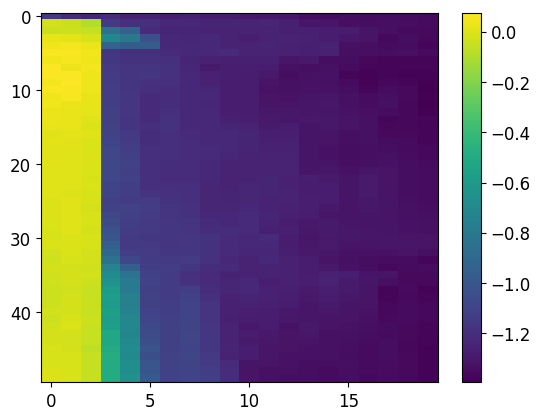

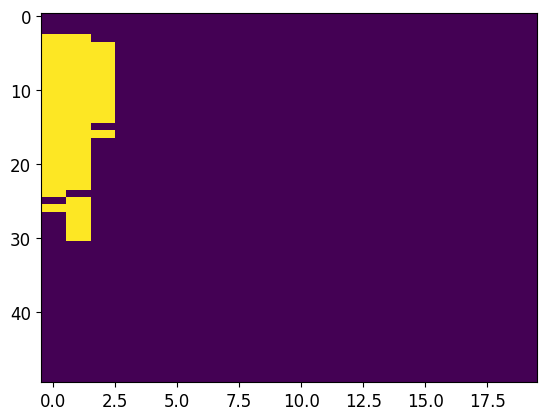

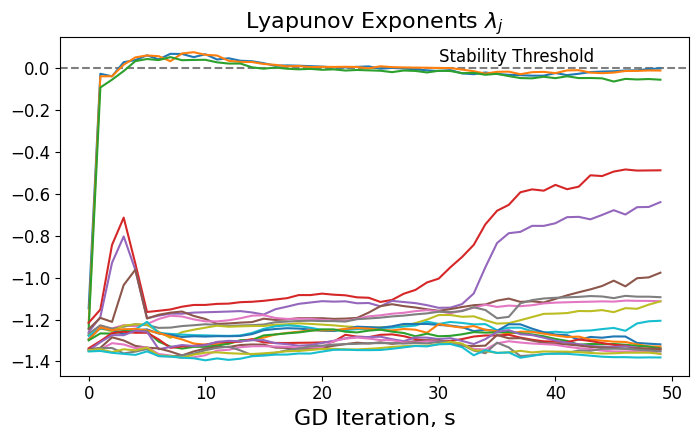

In [43]:
plt.imshow(LCEs, aspect = 'auto')
plt.colorbar()

plt.figure()
plt.imshow(LCEs > 0., aspect = 'auto')

plt.figure(figsize = (5.5 * 1.3, 3.5 * 1.3))
plt.plot(LCEs)
plt.xlabel('GD Iteration, s', fontsize = 16)
plt.title('Lyapunov Exponents $\\lambda_j$', fontsize = 16)
plt.axhline(0., linestyle = 'dashed', zorder = -1, alpha = 0.5, color = 'black')
plt.text(LCEs.shape[0] * 0.6, 0.03, 'Stability Threshold')
plt.savefig('lyap_flip_flop_over_training.pdf')
plt.tight_layout()
plt.show()

## Hamiltonian Analysis

In [11]:
model = model.cpu()
model.load_state_dict(import_checkpoint(checkpoints_all[0]))
hidden, adjoint, out, ell_z, loss = model.analysis_mode(inputs, targets)

In [12]:
jacs = torch.autograd.functional.jacobian(lambda h: model.eval_single_step(h)[1], hidden[0, :, :])
T = jacs.shape[0]
jacs = jacs[range(T), :, range(T), :].detach()

tensor([5.6843e-13, 6.8212e-13, 4.5475e-13, 0.0000e+00])


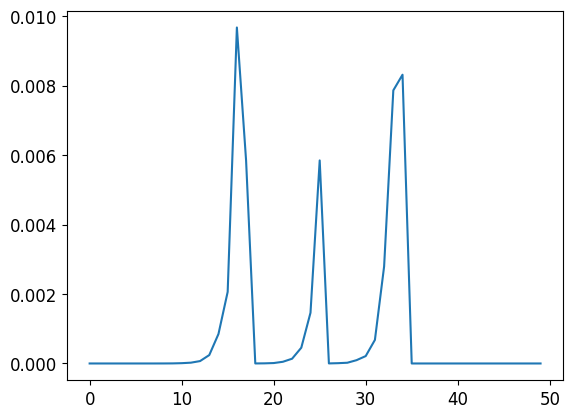

5.880621756659821e-06


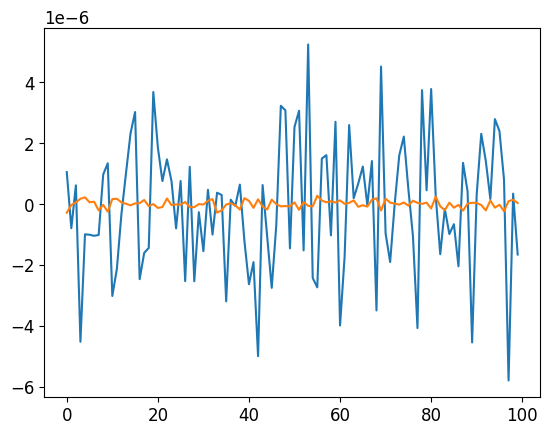

In [13]:
diffs = out - targets
res_term = (2. / ell_z.numel()) * diffs[0] @ model.W_out.weight.data

my_adjoints = []
# Manual backprop
my_adjoints.append(res_term[-1])
for i in range(adjoint.shape[1] - 1):
    my_adjoints.append(res_term[-2-i] + jacs[-2-i].T @ my_adjoints[-1])

my_adjoints = torch.flip(torch.stack(my_adjoints), (0,))  # Reverse time

max_diffs = torch.abs(my_adjoints - adjoint[0]).max(dim = 1)[0].detach()
max_diffs_nm = max_diffs / torch.abs(adjoint[0]).max()
print(max_diffs[-4:])
plt.plot(max_diffs_nm[-50:])
plt.show()

print(torch.abs(my_adjoints[0] - adjoint[0, -1]).max().item())

plt.plot(adjoint[0, -1])
plt.plot(my_adjoints[0].detach())
plt.show()

In [120]:
print(out.shape)

torch.Size([100, 300, 3])


In [23]:
def eval_model_small_steps(X, nstep):
    # Replace single step from time 1 to time 2 with n steps.
    # Updates becomes the form z_{t+dt} = (1-dt) * z_t + dt * f(z_t), which agrees with discrete when dt = 1.
    dt = 1. / nstep
    h = torch.zeros(X.shape[0], model.n_hidden).to(X.device)
    lerp = torch.linspace(0., 1., nstep+1)[:-1][:, None, None, None]
    X_lerp = X[None, :, :-1] * (1. - lerp) + X[None, :, 1:] * lerp
    X_lerp = torch.concatenate((X_lerp, X_lerp[:, :, :1]*0.), 2) # put a zero in final time.
    hidden = []
    for i1 in range(inputs.shape[1]):
        for i2 in range(nstep):
            h_next = model.eval_single_step(h, X_lerp[i2, :, i1, ])[1]
            hidden.append((1 - dt) * h + dt * h_next)
            h = h_next.clone()
    return hidden

def eval_adjoints_small_steps(inputs, target, nstep):
    hidden = eval_model_small_steps(inputs, nstep)
    for h in hidden:
        h.retain_grad() # For adjoints.
    output = model.W_out(torch.stack(hidden, 1))
    target_extend = target.repeat_interleave(nstep, dim = 1)
    print(target_extend.shape, output.shape)
    loss_unreduced = model.loss_fn_no_reduce(output, target_extend)
    loss = loss_unreduced.mean()
    loss.backward() # Perform BPTT.

    adjoint = torch.stack([h.grad for h in hidden], 1) # dL/dz defn of adjoint.
    hidden = torch.stack(hidden, 1)
    return hidden, adjoint, output, loss_unreduced, loss

In [31]:
nstep = 5
targets_const = targets * 0. + targets[:, -1:]
inputs_const = inputs * 0. + inputs[:, -1:]
print(targets_const.shape, targets.shape)
hidden, adjoint, out, ell_z, loss = eval_adjoints_small_steps(inputs_const, targets_const, 5)

torch.Size([100, 300, 3]) torch.Size([100, 300, 3])
torch.Size([100, 1500, 3]) torch.Size([100, 1500, 3])


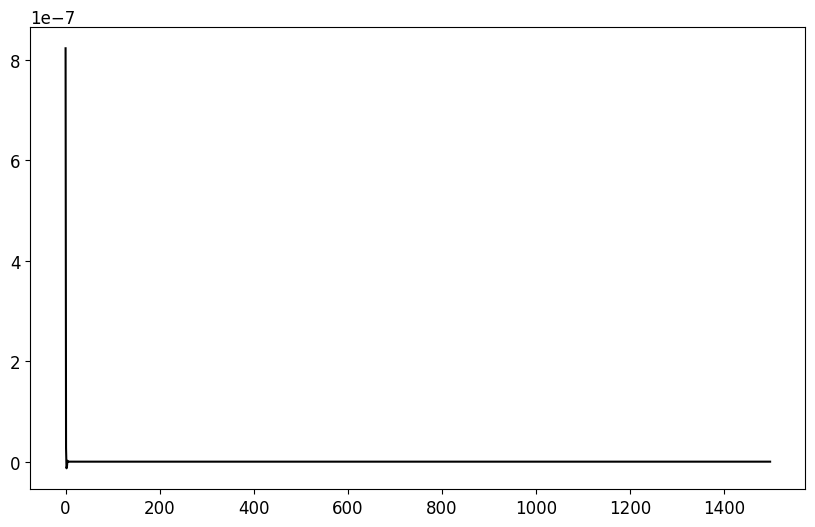

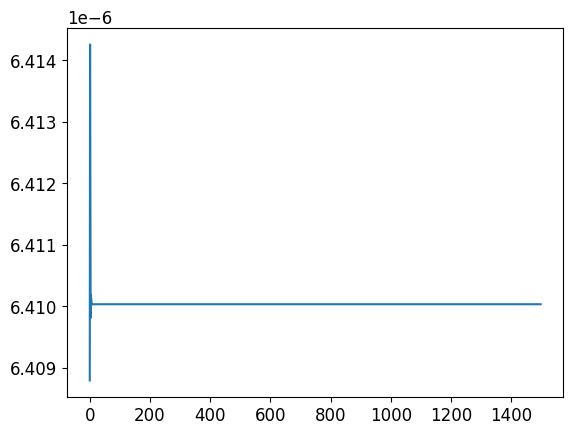

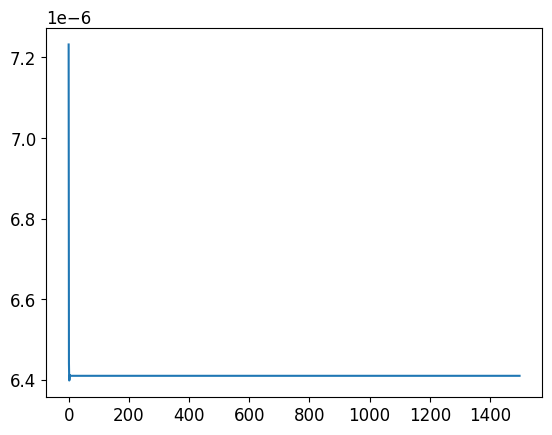

In [32]:
out, hidden = out.detach(), hidden.detach()
adjoint = adjoint.detach()
ell_z = ell_z.detach()

delta_z = (hidden[:, 1:] - hidden[:, :-1]) * nstep
inner = (adjoint[:, :-1] * delta_z).sum(-1)

plt.figure(figsize = (10, 6))
plt.plot(inner[0], c = 'black', zorder = 10)
plt.show()

plt.plot(ell_z[0, 1:].sum(-1) / ell_z.numel())
plt.show()

plt.plot(inner[0] + ell_z[0, 1:].sum(-1) / ell_z.numel())
plt.show()

In [ ]:
plt.plot(checkpoints[-1])

In [41]:
sys = lp.DiscreteDS(hidden_np[0, 0], 0, f, jac)
clv, hist = lp.CLV(sys, 20, 0, 10, 10, 69, True)

In [47]:
hist.shape

(11, 100)

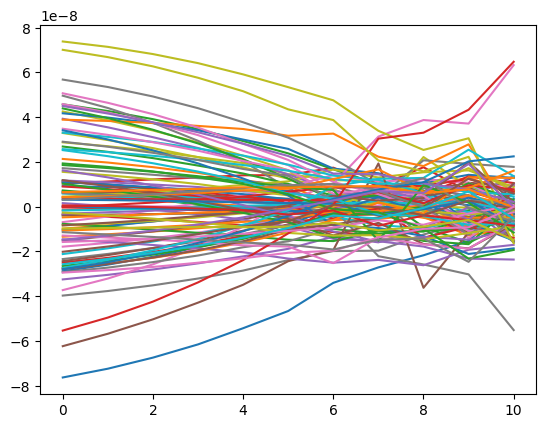

In [48]:
plt.plot(hist)
plt.show()

In [62]:
jacs

array([[[-8.69508535e-02,  3.37579623e-02, -4.96625043e-02, ...,
         -3.10650058e-02,  5.64782694e-03,  4.99634594e-02],
        [ 2.26393938e-02, -5.93786202e-02, -4.09858488e-02, ...,
          3.66050377e-02,  2.28834432e-02,  8.87591392e-03],
        [ 8.59953742e-03,  1.27256168e-02,  5.57751432e-02, ...,
          9.48582776e-04,  7.02520832e-03, -2.82602906e-02],
        ...,
        [-3.82785834e-02,  1.32820711e-01, -2.90776491e-02, ...,
          1.95311919e-01,  3.84066813e-02,  5.20332716e-03],
        [-3.54902744e-02, -2.40302435e-03, -3.80375646e-02, ...,
         -3.13128643e-02, -4.31765765e-02, -1.70923974e-02],
        [ 4.34825607e-02,  2.45109294e-02, -6.62011607e-03, ...,
         -4.38313838e-03,  4.19308729e-02,  8.61583743e-04]],

       [[-8.47032592e-02,  3.38825285e-02, -4.89629805e-02, ...,
         -3.25720571e-02,  7.90752098e-03,  4.97814231e-02],
        [ 1.85825378e-02, -6.35375753e-02, -3.73863541e-02, ...,
          3.90431732e-02,  1.83312949e

In [65]:
U, S, Vt = np.linalg.svd(jacs)

In [72]:
prod = jacs[0]
for i in range(10):
    prod = jacs[i+1] @ prod

U, S, Vt = np.linalg.svd(prod[None])

In [74]:
print(S.shape)
print(S)

(1, 100)
[[1.14840923e-05 9.01108615e-06 6.88102864e-06 5.98278439e-06
  5.63122558e-06 4.89010563e-06 4.00217414e-06 3.33155663e-06
  3.14646149e-06 2.95681366e-06 2.67488895e-06 1.98418502e-06
  1.87895409e-06 1.66788641e-06 1.40879445e-06 1.29605746e-06
  1.21608798e-06 1.13524038e-06 1.10821395e-06 9.85251518e-07
  8.18481396e-07 7.71764860e-07 5.96200437e-07 5.48207140e-07
  4.60659578e-07 4.22629768e-07 3.79101436e-07 3.54972059e-07
  3.51220763e-07 3.19291161e-07 3.11244321e-07 2.70064476e-07
  2.51519168e-07 2.05742111e-07 1.68989075e-07 1.58290064e-07
  1.44607171e-07 1.38599489e-07 1.12448518e-07 1.02865478e-07
  1.01453544e-07 7.90300376e-08 7.32922700e-08 6.93494755e-08
  5.43084973e-08 4.21039523e-08 3.34044472e-08 2.92589171e-08
  2.47316230e-08 2.22791154e-08 2.06056274e-08 1.71400316e-08
  1.55013922e-08 1.44005448e-08 1.40886289e-08 1.18206334e-08
  1.00051629e-08 7.37839345e-09 6.23160012e-09 5.74032066e-09
  5.32762590e-09 4.67772843e-09 3.53003093e-09 3.29114513e-09

In [73]:
var = S**2 
var_rat = var / np.sum(var, axis = 1, keepdims = True)
np.argmax(np.cumsum(var_rat, axis = 1) > .9, axis = 1)

array([8])

In [ ]:
U, S, Vt = np.linalg.svd(jacs)